In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from datetime import datetime
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

In [3]:
pd.options.display.max_columns = 200
pd.set_option("display.max_rows", 1000)

pd.options.display.max_info_columns = 200
pd.set_option("display.max_info_rows", 1000)

pd.options.display.max_colwidth = 200

plt.rcParams["figure.figsize"] = [15, 20] 

In [4]:
# kaggleからデータを読み込む
# https://take-tech-engineer.com/kaggle-colab-api/
path = "/content/drive/MyDrive/competition/kaggle.json"

f = open(path, 'r')
json_data = json.load(f) 
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

!kaggle datasets download -d luisvalgoi/2-years-restaurant-sale-with-multiple-external-var
!unzip "/content/2-years-restaurant-sale-with-multiple-external-var.zip"

filepath = "/content/sales.csv"
data = pd.read_csv(filepath, sep=';', index_col=0)

2-years-restaurant-sale-with-multiple-external-var.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/2-years-restaurant-sale-with-multiple-external-var.zip
replace sales.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ｙ
error:  invalid response [ｙ]
replace sales.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ｙ
error:  invalid response [ｙ]
replace sales.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sales.csv               
replace sales_one_hot_encoding.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sales_one_hot_encoding.csv  
replace sales_with_extra_features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sales_with_extra_features.csv  


In [5]:
data.head()

,DATE,SALES,IS_WEEKEND,IS_HOLIDAY,IS_FESTIVE_DATE,IS_PRE_FESTIVE_DATE,IS_AFTER_FESTIVE_DATE,IS_PEOPLE_WEEK_PAYMENT,IS_LOW_SEASON,AMOUNT_OTHER_OPENED_RESTAURANTS,WEATHER_PRECIPITATION,WEATHER_TEMPERATURE,WEATHER_HUMIDITY
0,20180214,132,0,0,0,0,0,0,1,7,0.0,28.0,66.75
1,20180215,149,0,0,0,0,0,0,1,7,0.0,28.6,61.50
2,20180216,130,0,0,0,0,0,0,1,7,0.0,30.6,65.25
3,20180217,174,1,0,0,0,0,0,1,7,0.0,31.5,65.75
4,20180218,185,1,0,0,0,0,0,1,7,0.0,33.4,58.50


In [6]:
data.DATE = data.DATE.astype("str")
data.DATE = data.DATE.apply(lambda x: datetime.strptime(x, "%Y%m%d"))

In [7]:
# DatetimeIndexの調整
time_df = pd.DataFrame(pd.date_range(data.DATE.min(), datetime.strptime("20191231", "%Y%m%d"), freq='d'),
             columns=["DATE"])
data = pd.merge(time_df, data,  how="left", on="DATE")

data = data.set_index("DATE").sort_index()
data.index.freq = "d"

In [8]:
# 外生変数の補完
data.IS_FESTIVE_DATE = data.IS_FESTIVE_DATE.interpolate('ffill')
data.AMOUNT_OTHER_OPENED_RESTAURANTS = data.AMOUNT_OTHER_OPENED_RESTAURANTS.interpolate('ffill')

data.IS_FESTIVE_DATE = data.IS_FESTIVE_DATE.interpolate('bfill')
data.AMOUNT_OTHER_OPENED_RESTAURANTS = data.AMOUNT_OTHER_OPENED_RESTAURANTS.interpolate('bfill')

Optimization terminated successfully.
         Current function value: 4.348978
         Iterations: 803
         Function evaluations: 1242
Optimization terminated successfully.
         Current function value: 4.335757
         Iterations: 68
         Function evaluations: 77
         Gradient evaluations: 77
                                 Unobserved Components Results                                 
Dep. Variable:                                   SALES   No. Observations:                  728
Model:                              local linear trend   Log Likelihood               -3156.431
                              + stochastic seasonal(7)   AIC                           6326.862
                   + stochastic freq_seasonal(365(10))   BIC                           6358.719
Date:                                 Wed, 12 Oct 2022   HQIC                          6339.176
Time:                                         01:47:30                                         
Sample:        

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/structural.py:1722: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


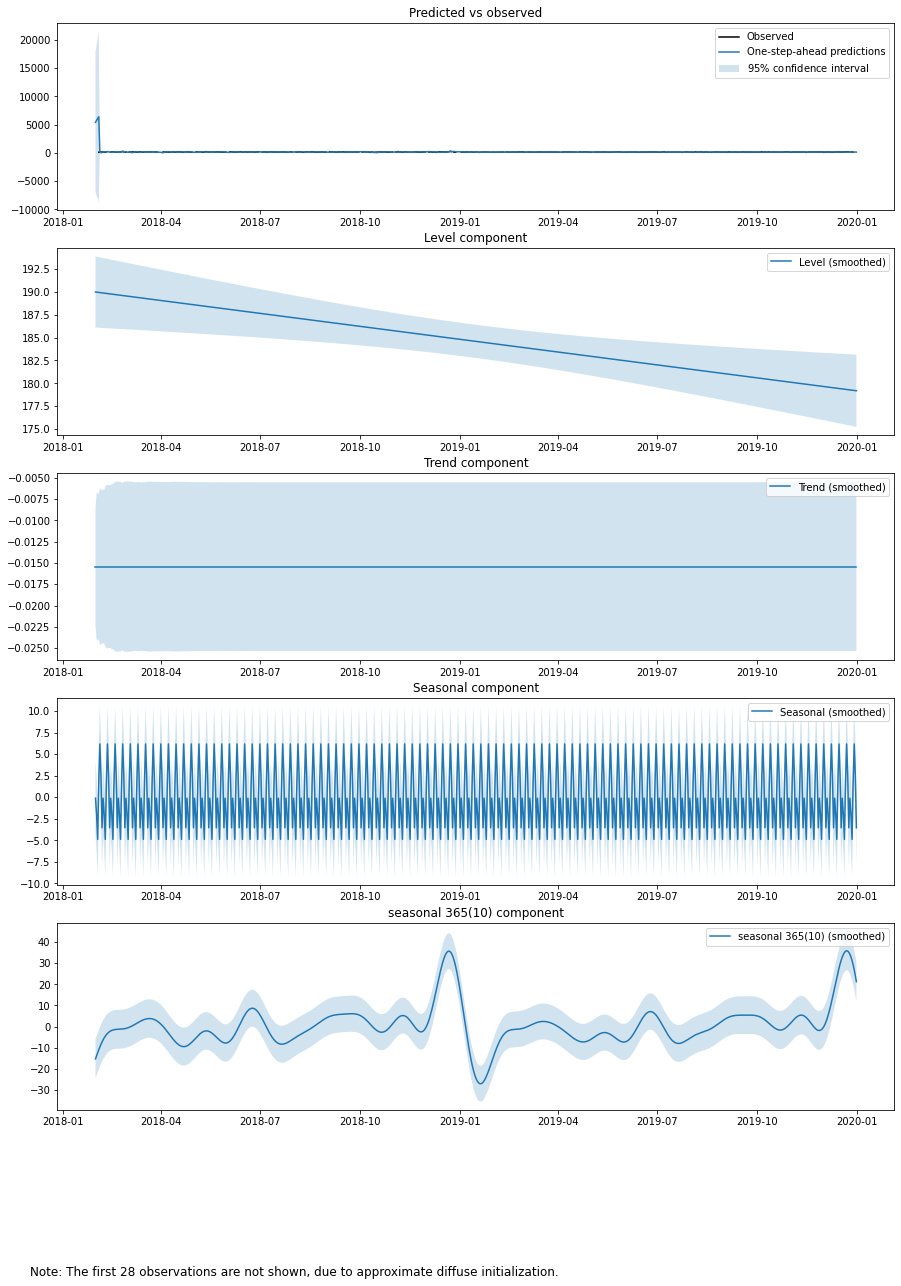

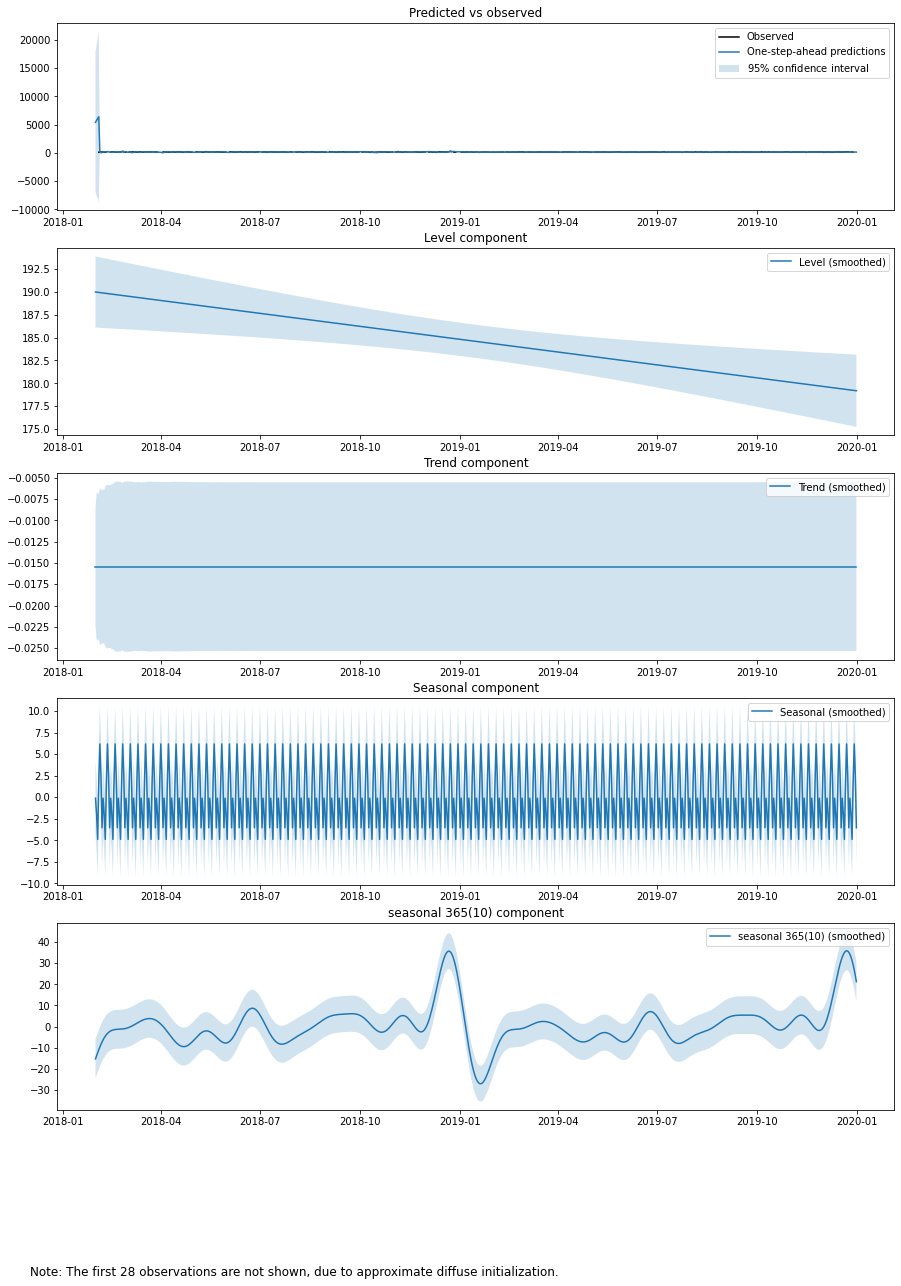

In [9]:
# モデルの作成と推定
model = sm.tsa.UnobservedComponents(
    endog=data[["SALES"]],
    level='local linear trend',
    seasonal=7,
    freq_seasonal=[{'period':365, "harmonics": 10}],
    exog=data[["IS_FESTIVE_DATE", "AMOUNT_OTHER_OPENED_RESTAURANTS"]]
)

start_params = model.fit(method='nm', maxiter=10**6).params
result = model.fit(
    method='bfgs',
    maxiter=10**6,
    start_params=start_params,
)

print(result.summary())
result.plot_components()

In [10]:
# 将来の予測
steps=60
fes_future = [0]*steps
restaurants_future = [0]*steps

forecast = result.forecast(steps=steps, 
                             exog=[fes_future, restaurants_future])
forecast.head()

2020-01-01    197.202209
2020-01-02    191.954819
2020-01-03    185.610514
2020-01-04    188.698018
2020-01-05    189.558425
Freq: D, Name: predicted_mean, dtype: float64

In [11]:
data.query("IS_FESTIVE_DATE==1")

,SALES,IS_WEEKEND,IS_HOLIDAY,IS_FESTIVE_DATE,IS_PRE_FESTIVE_DATE,IS_AFTER_FESTIVE_DATE,IS_PEOPLE_WEEK_PAYMENT,IS_LOW_SEASON,AMOUNT_OTHER_OPENED_RESTAURANTS,WEATHER_PRECIPITATION,WEATHER_TEMPERATURE,WEATHER_HUMIDITY
DATE,,,,,,,,,,,,
2018-05-13,225.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0,23.0,73.25
2018-12-08,153.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,1.8,20.3,87.00
2019-11-08,159.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,20.2,80.25
2019-12-05,174.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,0.9,21.5,84.00


In [12]:
# 外生変数の変更
data_apply = data.copy()
data_apply[["IS_FESTIVE_DATE"]] = 0

result_apply = result.apply(endog=data_apply[["SALES"]],
                exog=data_apply[["IS_FESTIVE_DATE", "AMOUNT_OTHER_OPENED_RESTAURANTS"]]
                )

prediction = result.predict(start=datetime.strptime("20190101", "%Y%m%d"), 
                            end=datetime.strptime("20191231", "%Y%m%d"))

prediction_apply = result_apply.predict(start=datetime.strptime("20190101", "%Y%m%d"), 
                            end=datetime.strptime("20191231", "%Y%m%d"))

print(prediction.sum() - prediction_apply.sum())
# 42.287497166733374

42.287497166733374


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
